# Taxi Fare Prediction
This is a toy example to show why not using experiment tracking tools such as MLFlow is a bad idea.
Start with skimming through the notebook, try to see problems and then go back to the code and run it.

You don't have to understand everything. Just try to see if you can spot the problems.

In [19]:
import os
import requests

# Create necessary folders if not exists
if not os.path.exists("data"):
    os.makedirs("data")

if not os.path.exists("models"):
    os.makedirs("models")

url = "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet"
file_content = requests.get(url, allow_redirects=True).content
with open("./data/green_tripdata_2021-01.parquet", "wb") as f:
    f.write(file_content)

url = "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet"
file_content = requests.get(url, allow_redirects=True).content
with open("./data/green_tripdata_2021-02.parquet", "wb") as f:
    f.write(file_content)

## Imports

In [3]:
import pandas as pd

In [4]:
import pickle

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

## Data
We will use the Green Taxi data from NYC. The data is available at https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page and we will use the data for January 2021.
The data is available in CSV and Parquet formats. We will use the Parquet format as it is more efficient.
The data is available in the data folder.


In [7]:
df = pd.read_parquet("./data/green_tripdata_2021-01.parquet")

df["duration"] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ["PULocationID", "DOLocationID"]
numerical = ["trip_distance"]

df[categorical] = df[categorical].astype(str)

## EDA
Let's try a simple linear regression model with the following features:
- PULocationID
- DOLocationID
- trip_distance
- duration

In [8]:
train_dicts = df[categorical + numerical].to_dict(orient="records")

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = "duration"
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

9.838799799829628

In [9]:
sns.set(rc={"figure.figsize": (12.0, 6)})

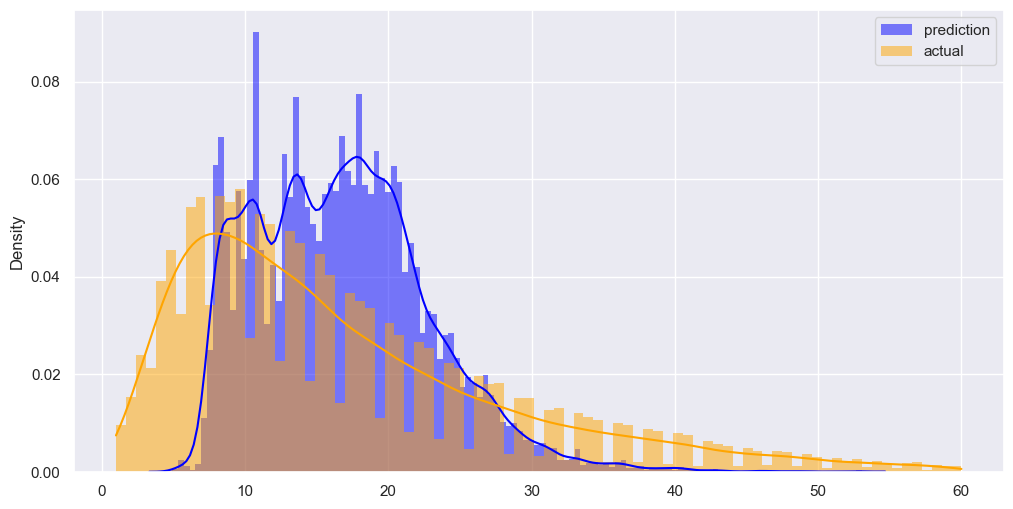

In [10]:
sns.histplot(
    y_pred, label="prediction", kde=True, stat="density", linewidth=0, color="blue"
)
sns.histplot(
    y_train, label="actual", kde=True, stat="density", linewidth=0, color="orange"
)

plt.legend()

# Hint
There is something wrong with the code below and first data reading code. Can you spot it?

In [11]:
def read_dataframe(filename):
    if filename.endswith(".csv"):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith(".parquet"):
        df = pd.read_parquet(filename)

    df["duration"] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ["PULocationID", "DOLocationID"]
    df[categorical] = df[categorical].astype(str)

    return df

In [12]:
df_train = read_dataframe("./data/green_tripdata_2021-01.parquet")
df_val = read_dataframe("./data/green_tripdata_2021-02.parquet")

In [13]:
len(df_train), len(df_val)

(73908, 61921)

In [14]:
df_train["PU_DO"] = df_train["PULocationID"] + "_" + df_train["DOLocationID"]
df_val["PU_DO"] = df_val["PULocationID"] + "_" + df_val["DOLocationID"]

In [15]:
categorical = ["PU_DO"]  #'PULocationID', 'DOLocationID']
numerical = ["trip_distance"]

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient="records")
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient="records")
X_val = dv.transform(val_dicts)

In [16]:
target = "duration"
y_train = df_train[target].values
y_val = df_val[target].values

## Model
Try a few models and see which one performs the best.

In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.758715205596356

In [20]:
with open("models/lin_reg.bin", "wb") as f_out:
    pickle.dump((dv, lr), f_out)

In [21]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

11.167275941179728

# Questions
- Where is the Ridge regression model?
- Did I try different hyperparameters for the Lasso regression model?
- Did I try different hyperparameters for the Linear regression model?

# Answer for All
We don't know. We didn't track anything.

# Problem with the data reading code
Well, I created a function to read the data but I didn't delete the first data reading code. Soooo code duplication.

Now, go to duration-prediction.ipynb and see the difference.